## Time to get your hands dirty. Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.

Right now, state-of-the-art analyses seems to say that many channels are all at play, in particular the main possibilities for the formation of black hole binaries are: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT).

LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.

### Let's have a look at the data

In [55]:
from scipy.stats import norm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import MeanShift, estimate_bandwidth

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,5]

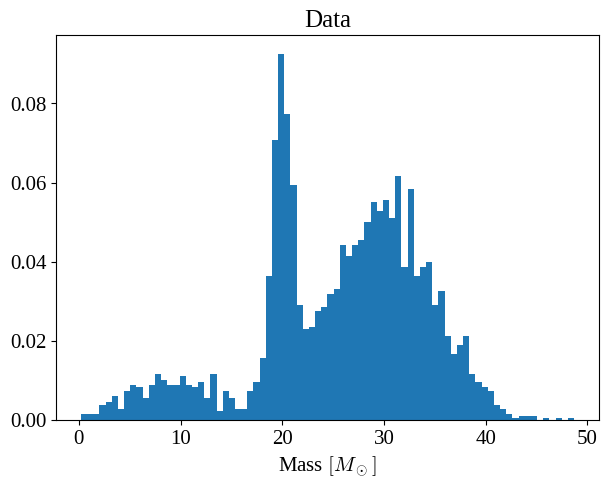

In [56]:
data=np.load('formationchannels.npy')

#let's have a look at the data
N_bin=80
plt.hist(data[data>0], density=True, bins=N_bin)
plt.xlabel('Mass $[M_\odot]$')
plt.title('Data')
plt.show()

Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

2) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

3) For each of this fits, compute the AIC. Plot $N$ vs AIC: which model is preferred?

4) Plot the preferred solution on top of the input data. You should get a very nice fit!

5) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

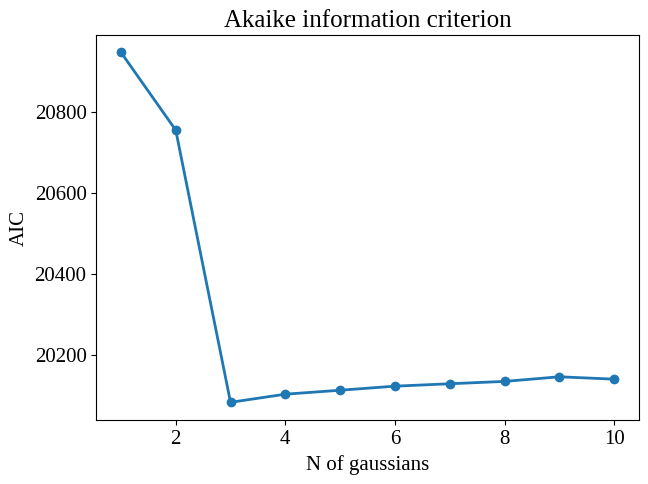

The best model is the one with  3  components


In [57]:
components=np.linspace(1,10,10, dtype=int)

gm = np.array([GaussianMixture(n_components=c).fit(data) for c in components])

#compute the AIC and plot its values as a function of the number of the gaussian
AIC=np.empty(len(components))
for i in range(len(components)):
    AIC[i] = gm[i].aic(data)
    
plt.plot(components, AIC, lw=2)
plt.scatter(components, AIC)
plt.ylabel('AIC')
plt.xlabel('N of gaussians')
plt.title('Akaike information criterion')
plt.show()

min_i=np.argmin(AIC)
best_model=components[min_i]

print("The best model is the one with ", best_model, " components")

The AIC criterion prefers the model with 3 gaussians, let's try to plot this result.

GaussianMixture(n_components=3)


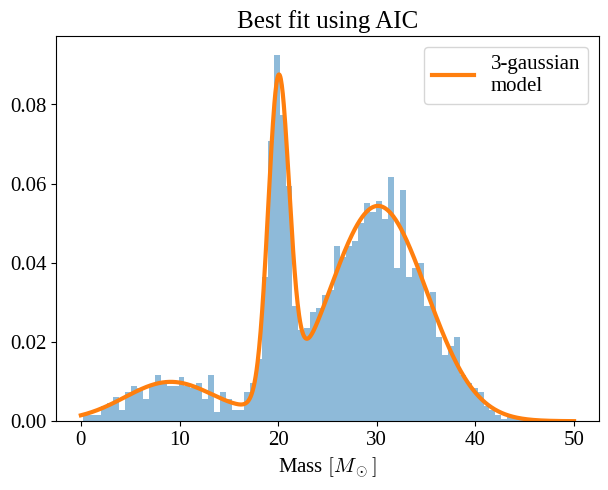

In [58]:
best_model=gm[min_i]
print(best_model)

plt.hist(data[data>0], density=True, bins=N_bin, alpha=0.5)
x=np.linspace(0,50,1000)

plt.plot(x, np.exp(best_model.score_samples(x[:, np.newaxis])), lw=3, label='3-gaussian\nmodel')
plt.xlabel('Mass $[M_\odot]$')
plt.title('Best fit using AIC')
plt.legend()
plt.show()

We can plot the contribution of each individual gaussian.

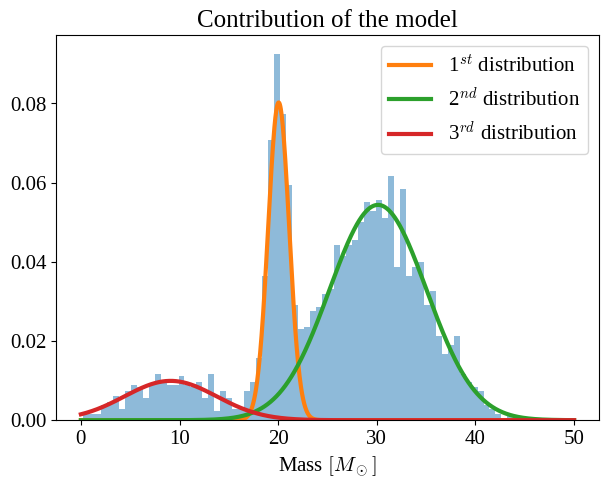

In [59]:
#plot the contribution of each gaussian distribution

contr=best_model.predict_proba(x.reshape(-1, 1))
pdf=np.exp(best_model.score_samples(x[:, np.newaxis]))
pdf_contr=contr*pdf[:, np.newaxis]

plt.hist(data[data>0], density=True, bins=N_bin, alpha=0.5)

plt.plot(x, pdf_contr[:,0], lw=3, label='1$^{st}$ distribution')
plt.plot(x, pdf_contr[:,1], lw=3, label='2$^{nd}$ distribution')
plt.plot(x, pdf_contr[:,2], lw=3, label='3$^{rd}$ distribution')
plt.xlabel('Mass $[M_\odot]$')
plt.title('Contribution of the model')
plt.legend()
plt.show()

### Try to use now different algorithms

Try to use Mean-shift as a further verification of the result obtained.

In [60]:
bandwidth = estimate_bandwidth(data)
print(bandwidth)

5.01825412872019


In [61]:
ms = MeanShift(bandwidth=bandwidth)
ms.fit(data)

MeanShift(bandwidth=5.01825412872019)

In [62]:
MSlabels = ms.labels_
MScenters = ms.cluster_centers_
n_clusters = len(np.unique(MSlabels[MSlabels >= 0]))
print('bandwidth= ', round(bandwidth,3))
print("number of estimated clusters :", n_clusters)

bandwidth=  5.018
number of estimated clusters : 3


Also with Mean-shift we obtained that there are 3 clusters

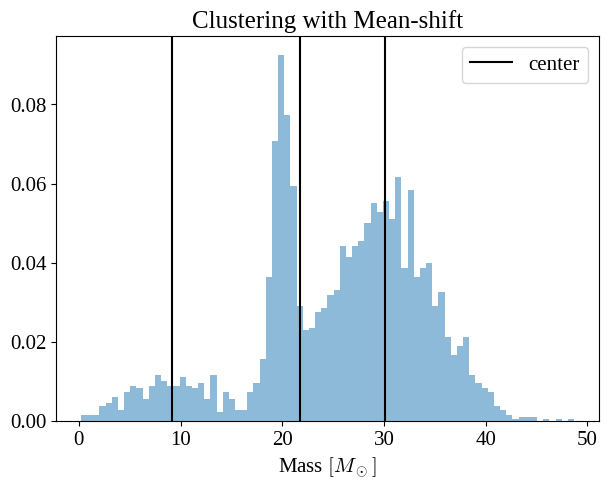

In [63]:
plt.hist(data[data>0], density=True, bins=N_bin, alpha=0.5)
plt.title('Clustering with Mean-shift')
plt.xlabel('Mass $[M_\odot]$')

plt.axvline(MScenters[0],color='black', label='center')
plt.axvline(MScenters[1],color='black')
plt.axvline(MScenters[2],color='black')

plt.legend()
plt.show()

The centers of the $1^{st}$ and $3^{rd}$ clusters coincide quite well with the data, while the second peak is slightly shifted.